# GA Project 4: West Nile virus
by: Nicholas Lim, Kwek Jun Hong, Malcolm Lau
***

[workflow gsheet](https://docs.google.com/spreadsheets/d/1-xSVNsQZX-uWmbI-ublY9yNhlsWAwXqziErKFpnPgpg/edit?usp=sharing)

# Background
***
The city of Chicago has been having to deal with seasonal upticks of incidences of the West Nile virus, and it is becoming a health hazard. We have been tasked by the Chicago Department of Public Health to come up with a predictive model to identify locations where mosquitoes would have a higher chance of carrying the disease, so that resources can be effectively allocated to stop its spread.

One of the more efficient ways to prevent the disease would be to spray Zenivex, a pesticide, and by identifying the potential hotspots we can find an effective balance between preventability and cost. To this end, we will be examining the [West Nile Virus dataset](www.kaggle.com/c/predict-west-nile-virus/data) to train a model which can effectively predict the prevalence of the virus in certain areas.



# Problem Statement
***
To train a model which can predict the prevalence of the West Nile virus amongst mosquitoes within the Chicago city area, and to run a cost-benefit analysis to determine the most effective way to apply pesticides.

# Imports

In [36]:
# fabulous four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time

# Machine Learning Libraries
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix , plot_roc_curve
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnpipe

# Load Data

We can start by cleaning up the column names. We can create a function to clean them at one go. This function will
1. remove whitespaces at the front and end
2. change whitespaces in the middle to `_`
3. change capitals to lowercase

In [37]:
def pythonic_cols(df):
  new_cols = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).strip().lower() for name in df.columns]
  df.columns = new_cols

In [38]:
train = pd.read_csv('data/train.csv')
pythonic_cols(train)
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [39]:
weather = pd.read_csv('data/weather.csv')
pythonic_cols(weather)
weather

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


In [40]:
spray = pd.read_csv('data/spray.csv')
pythonic_cols(spray)
spray.head()

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [41]:
test = pd.read_csv('data/test.csv')
pythonic_cols(test)
test.head()

,id,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


# Dependent Variable

Let's first take a look at the dependent variable. We can see that it is severely imbalanced, which would be a problem later.

In [42]:
train.wnv_present.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

# Feature Selection

We can choose the features that are relevant to our analysis from each dataset and combine them for easier data cleaning and analysis.

## `train`/`test` datasets

In [43]:
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       10506 non-null  object 
 1   address                    10506 non-null  object 
 2   species                    10506 non-null  object 
 3   block                      10506 non-null  int64  
 4   street                     10506 non-null  object 
 5   trap                       10506 non-null  object 
 6   address_number_and_street  10506 non-null  object 
 7   latitude                   10506 non-null  float64
 8   longitude                  10506 non-null  float64
 9   address_accuracy           10506 non-null  int64  
 10  num_mosquitos              10506 non-null  int64  
 11  wnv_present                10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Drop Duplicates

We can first define a function to print the duplicated rows and remove them.

In [45]:
def remove_dupe(df):
    dupe = df[df.duplicated()]
    print(f'The number of removed duplicated rows is: {len(dupe)}')
    df.drop_duplicates(inplace=True, ignore_index=True)
    return df

In [46]:
remove_dupe(train)

The number of removed duplicated rows is: 813


,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9688,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
9689,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
9690,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
9691,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


### Satellite Traps

Let's examine the "satellite traps" - traps that are set up near an established trap to enhance surveillance efforts. These have alphabets behind their trap numbers.

In [47]:
train[train.trap.str.contains(r'(?<=[1-9])[A-Z]$', na=False)].count()

date                         14
address                      14
species                      14
block                        14
street                       14
trap                         14
address_number_and_street    14
latitude                     14
longitude                    14
address_accuracy             14
num_mosquitos                14
wnv_present                  14
dtype: int64

### Address Columns

The address details are not as important to us because we can compare the coordinates with the ones provided in the `spray` dataset, so we will remove them. 

### `num_mosquitoes` column


            num_mosquitos  wnv_present
date                                  
2007-05-29             40            0
2007-06-05            127            0
2007-06-26            215            0
2007-06-29             85            0
2007-07-02            240            0
...                   ...          ...
2013-08-29           2345           35
2013-09-06           2451           31
2013-09-12           2160           23
2013-09-19           1017           11
2013-09-26            505            4

[95 rows x 2 columns]


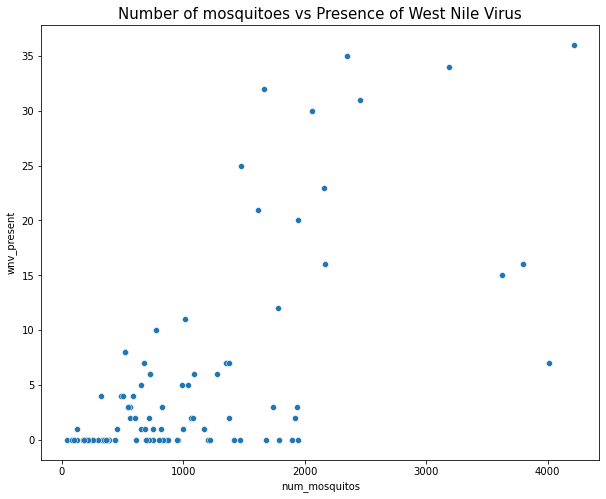

In [48]:
num_mos = train.groupby('date').sum()[['num_mosquitos','wnv_present']]
print(num_mos)

plt.figure(figsize = (10,8))
sns.scatterplot(x = 'num_mosquitos', y = 'wnv_present', data = num_mos)
plt.title('Number of mosquitoes vs Presence of West Nile Virus', fontsize = 15);

The scatter plot above shows the relatioship between the `num_mosquitoes` and `wnv_present`. It can be seen that there is no discernible pattern between the number of mosquitoes and the presence of West Nile Virus. Thus, we will drop the `num_mosquitoes` column.

### Features selected for `train`/`test`

Based on the above analysis and our domain knowledge, we will keep the features that are most relevant to us:
1. date
2. species
3. latitude
4. longitude
5. wnv_present (dependent variable)

In [49]:
train = train[['date', 'species', 'latitude', 'longitude', 'wnv_present']]
train.head()

,date,species,latitude,longitude,wnv_present
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9693 entries, 0 to 9692
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         9693 non-null   object 
 1   species      9693 non-null   object 
 2   latitude     9693 non-null   float64
 3   longitude    9693 non-null   float64
 4   wnv_present  9693 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 378.8+ KB


Whatever we do for `train`, we have to do unto `test` too, except without the dependent variable.

In [51]:
test = test[['date', 'species', 'trap', 'latitude', 'longitude']]
test.head()

,date,species,trap,latitude,longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991


## `weather` datasets

In [52]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [53]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station       2944 non-null   int64  
 1   date          2944 non-null   object 
 2   tmax          2944 non-null   int64  
 3   tmin          2944 non-null   int64  
 4   tavg          2944 non-null   object 
 5   depart        2944 non-null   object 
 6   dew_point     2944 non-null   int64  
 7   wet_bulb      2944 non-null   object 
 8   heat          2944 non-null   object 
 9   cool          2944 non-null   object 
 10  sunrise       2944 non-null   object 
 11  sunset        2944 non-null   object 
 12  code_sum      2944 non-null   object 
 13  depth         2944 non-null   object 
 14  water1        2944 non-null   object 
 15  snow_fall     2944 non-null   object 
 16  precip_total  2944 non-null   object 
 17  stn_pressure  2944 non-null   object 
 18  sea_level     2944 non-null 

We can again start off by removing duplicated rows, however it seems like there are none.

### Drop Duplicates

In [54]:
remove_dupe(weather)

The number of removed duplicated rows is: 0


,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


Taking a look at the nominal variable `code_sum`, we notice that it is a description of weather patterns captured by the weather station on a certain day. However for our case, the rest of the information suffices and thus we do not need it.

In [55]:
weather.code_sum.value_counts()

                        1609
RA                       296
RA BR                    238
BR                       110
TSRA RA BR                92
                        ... 
TSRA RA HZ FU              1
TSRA DZ FG+ FG BR HZ       1
HZ FU                      1
TS TSRA RA FG BR HZ        1
RA VCTS                    1
Name: code_sum, Length: 98, dtype: int64

We can also do a check on the precipitation columns. It seems like out of all of them, only the total precipitation column gives the most useful information - the rest are null values.

In [56]:
for col in ['depth', 'water1', 'snow_fall', 'precip_total']:
  print(col)
  print(weather[col].value_counts())
  print('===============')

depth
M    1472
0    1472
Name: depth, dtype: int64
water1
M    2944
Name: water1, dtype: int64
snow_fall
M      1472
0.0    1459
  T      12
0.1       1
Name: snow_fall, dtype: int64
precip_total
0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
1.30       1
1.19       1
4.73       1
2.09       1
1.18       1
Name: precip_total, Length: 168, dtype: int64


According to this [website](https://www.differencebetween.com/difference-between-dewpoint-and-wet-bulb-temperature/), there is a direct correlation between temperature and dewpoint which indicates the humidity. We can then remove the wet bulb temperature. Furthermore, air pressure has a significant impact on the weather patterns in the area.

Based on the above analysis, we will be choosing a few relevant columns for our analysis. The pertinent ones are:
1. station
2. date
3. tavg
4. dew_point
5. precip_total
6. stn_pressure
7. sea_level
8. result_dir
9. avg_speed

In [57]:
weather = weather[['station', 'date', 'tavg', 'dew_point', 'precip_total', 'stn_pressure', 'sea_level', 'result_dir', 'avg_speed']]
weather.head()

,station,date,tavg,dew_point,precip_total,stn_pressure,sea_level,result_dir,avg_speed
0,1,2007-05-01,67,51,0.00,29.10,29.82,27,9.2
1,2,2007-05-01,68,51,0.00,29.18,29.82,25,9.6
2,1,2007-05-02,51,42,0.00,29.38,30.09,4,13.4
3,2,2007-05-02,52,42,0.00,29.44,30.08,2,13.4
4,1,2007-05-03,56,40,0.00,29.39,30.12,7,11.9


Since both weather stations give important information, we can combine them horizontally based on the date for easier merging later.

In [58]:
weather_stn1 = weather[weather['station'] == 1].drop('station', axis = 1)
weather_stn2 = weather[weather['station'] == 2].drop('station', axis = 1)
weather = weather_stn1.merge(weather_stn2, on='date', suffixes = ('_1', '_2'))
weather.head()

,date,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,result_dir_1,avg_speed_1,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2
0,2007-05-01,67,51,0.00,29.10,29.82,27,9.2,68,51,0.00,29.18,29.82,25,9.6
1,2007-05-02,51,42,0.00,29.38,30.09,4,13.4,52,42,0.00,29.44,30.08,2,13.4
2,2007-05-03,56,40,0.00,29.39,30.12,7,11.9,58,40,0.00,29.46,30.12,6,13.2
3,2007-05-04,58,41,T,29.31,30.05,8,10.8,M,42,0.00,29.36,30.04,7,10.4
4,2007-05-05,60,38,T,29.40,30.10,7,12.0,60,39,T,29.46,30.09,7,11.5


## Merging datasets

In [59]:
train = train.merge(weather, on='date')
test = test.merge(weather, on = 'date')

# Notes from other people (TO DELETE)
- Test and train data contain multiple entries for the same locations... this could be consolidated.
- Weather contains two different stations, and dates are not standardized with train and test datasets.
- Weather data is in different dtypes.
- Spray data is for only two weeks in 2011, and a few weeks in 2013. This is not enough to see a consistent effect of spraying, and determine how much spraying really effects mosquito population.

# Data Cleaning

Our data cleaning will involve two steps:
1. imputing missing values
2. changing datatypes

## `train` dataset

We will first examine the `train` dataset and the datatypes of the features.

In [60]:
train.head()

,date,species,latitude,longitude,wnv_present,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,result_dir_1,avg_speed_1,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            9693 non-null   object 
 1   species         9693 non-null   object 
 2   latitude        9693 non-null   float64
 3   longitude       9693 non-null   float64
 4   wnv_present     9693 non-null   int64  
 5   tavg_1          9693 non-null   object 
 6   dew_point_1     9693 non-null   int64  
 7   precip_total_1  9693 non-null   object 
 8   stn_pressure_1  9693 non-null   object 
 9   sea_level_1     9693 non-null   object 
 10  result_dir_1    9693 non-null   int64  
 11  avg_speed_1     9693 non-null   object 
 12  tavg_2          9693 non-null   object 
 13  dew_point_2     9693 non-null   int64  
 14  precip_total_2  9693 non-null   object 
 15  stn_pressure_2  9693 non-null   object 
 16  sea_level_2     9693 non-null   object 
 17  result_dir_2    9693 non-null   i

### Missing values

It seems like everything is in order and there are no null values, but that is a cruel trick. According to the [data dictionary](https://www.kaggle.com/c/predict-west-nile-virus/data?select=noaa_weather_qclcd_documentation.pdf), there are three types of missing values:
1. `*`: Not all stations report snow totals
2. `M`: Missing Data, or data that are not normally reported for the station
3. `-`: values not available for sunrise/sunset

And additional `T` values for trace amounts. We can write a function to replace them with suitable values.

In [62]:
 def missing_no(df):
    df.replace(r'\s*M+\s*', 0, regex=True, inplace=True)
    df.replace('-', 0, inplace=True)
    df.replace('*', 0, inplace=True)
    df.replace(r'^\s*T+(?!\d)+', 1e-5, regex=True, inplace=True)

missing_no(train)

In [63]:
train.head()

,date,species,latitude,longitude,wnv_present,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,result_dir_1,avg_speed_1,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0,74,58,0.00,29.39,30.11,18,6.5,77,59,0.00,29.44,30.09,16,7.4


In [64]:
missing_no(test)
test

,date,species,trap,latitude,longitude,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,result_dir_1,avg_speed_1,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,74,56,0.00,29.28,29.99,18,10.0,76,55,0.00,29.34,29.97,18,10.4
1,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,74,56,0.00,29.28,29.99,18,10.0,76,55,0.00,29.34,29.97,18,10.4
2,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,74,56,0.00,29.28,29.99,18,10.0,76,55,0.00,29.34,29.97,18,10.4
3,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,74,56,0.00,29.28,29.99,18,10.0,76,55,0.00,29.34,29.97,18,10.4
4,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,74,56,0.00,29.28,29.99,18,10.0,76,55,0.00,29.34,29.97,18,10.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,68,61,0.32,29.03,29.78,17,7.9,71,63,0.72,29.10,29.78,17,7.9
116289,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,68,61,0.32,29.03,29.78,17,7.9,71,63,0.72,29.10,29.78,17,7.9
116290,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,68,61,0.32,29.03,29.78,17,7.9,71,63,0.72,29.10,29.78,17,7.9
116291,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,68,61,0.32,29.03,29.78,17,7.9,71,63,0.72,29.10,29.78,17,7.9


### Changing dtypes

From the information table, some of the columns aren't in the right dtype. We can create a function to correct all the wrong datatypes.

In [65]:
def changing_types(df):
    df['date'] = pd.to_datetime(df['date'])
    df['tavg_1'] = df['tavg_1'].astype(int)
    df['tavg_2'] = df['tavg_2'].astype(int)
    df['avg_speed_1'] = df['avg_speed_1'].astype(float)
    df['avg_speed_2'] = df['avg_speed_2'].astype(float)
    df['precip_total_1'] = df['precip_total_1'].astype(float)
    df['precip_total_2'] = df['precip_total_2'].astype(float)
    df.info()

In [66]:
changing_types(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            9693 non-null   datetime64[ns]
 1   species         9693 non-null   object        
 2   latitude        9693 non-null   float64       
 3   longitude       9693 non-null   float64       
 4   wnv_present     9693 non-null   int64         
 5   tavg_1          9693 non-null   int32         
 6   dew_point_1     9693 non-null   int64         
 7   precip_total_1  9693 non-null   float64       
 8   stn_pressure_1  9693 non-null   object        
 9   sea_level_1     9693 non-null   object        
 10  result_dir_1    9693 non-null   int64         
 11  avg_speed_1     9693 non-null   float64       
 12  tavg_2          9693 non-null   int32         
 13  dew_point_2     9693 non-null   int64         
 14  precip_total_2  9693 non-null   float64       
 15  stn_

In [67]:
changing_types(test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            116293 non-null  datetime64[ns]
 1   species         116293 non-null  object        
 2   trap            116293 non-null  object        
 3   latitude        116293 non-null  float64       
 4   longitude       116293 non-null  float64       
 5   tavg_1          116293 non-null  int32         
 6   dew_point_1     116293 non-null  int64         
 7   precip_total_1  116293 non-null  float64       
 8   stn_pressure_1  116293 non-null  object        
 9   sea_level_1     116293 non-null  object        
 10  result_dir_1    116293 non-null  int64         
 11  avg_speed_1     116293 non-null  float64       
 12  tavg_2          116293 non-null  int32         
 13  dew_point_2     116293 non-null  int64         
 14  precip_total_2  116293 non-null  flo

### Creating `year`, `month` and `week` columns

Additional time related columns would be created from the `date` columns.

In [68]:
def preprocess_date(df):
    """Function to create additional time related columns"""
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week
    return df

In [69]:
# create the columns for both train and test datasets
preprocess_date(train)
preprocess_date(test);

In [70]:
train.head()

,date,species,latitude,longitude,wnv_present,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,...,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2,year,month,week_of_year
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,74,58,0.0,29.39,30.11,...,77,59,0.0,29.44,30.09,16,7.4,2007,5,22
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0,74,58,0.0,29.39,30.11,...,77,59,0.0,29.44,30.09,16,7.4,2007,5,22
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0,74,58,0.0,29.39,30.11,...,77,59,0.0,29.44,30.09,16,7.4,2007,5,22
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,74,58,0.0,29.39,30.11,...,77,59,0.0,29.44,30.09,16,7.4,2007,5,22
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0,74,58,0.0,29.39,30.11,...,77,59,0.0,29.44,30.09,16,7.4,2007,5,22


In [71]:
train.columns

Index(['date', 'species', 'latitude', 'longitude', 'wnv_present', 'tavg_1',
       'dew_point_1', 'precip_total_1', 'stn_pressure_1', 'sea_level_1',
       'result_dir_1', 'avg_speed_1', 'tavg_2', 'dew_point_2',
       'precip_total_2', 'stn_pressure_2', 'sea_level_2', 'result_dir_2',
       'avg_speed_2', 'year', 'month', 'week_of_year'],
      dtype='object')

In [72]:
from scipy.stats import normaltest 

normaltest(train['tavg_1'])

NormaltestResult(statistic=997.3058293850166, pvalue=2.7402536447702883e-217)

In [73]:
test.head()

,date,species,trap,latitude,longitude,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,...,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2,year,month,week_of_year
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24


# Exploratory Data Analysis

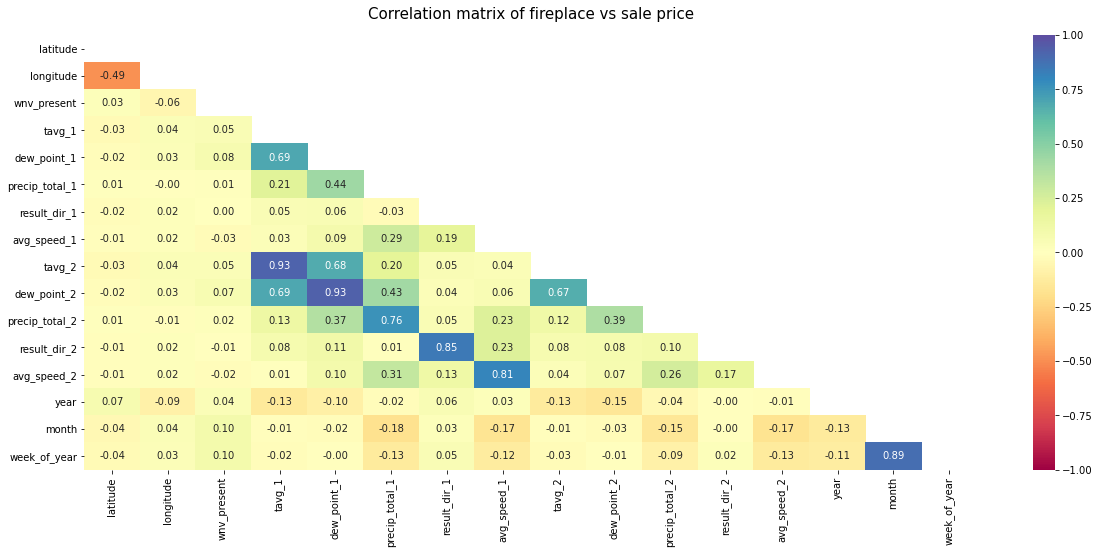

In [74]:
corr = train.corr(method='kendall')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(
    corr, annot=True, fmt=".2f", mask=mask, cmap="Spectral", vmax=1, vmin=-1
)
heatmap.set_title(
    "Correlation matrix of fireplace vs sale price", fontdict={"fontsize": 15}, pad=16
);

- OHE species
- corr matrix
- boxplot

# Modeling
***
The following models would be used:

|                |                  Models                 |
|:--------------:|:---------------------------------------:|
| Baseline Model |               BernoulliNB               |
|     Model 1    |            Logistic Regression          |
|     Model 2    |          Random Forest Classifier       |
|     Model 3    |        Gradient Boosting Classifier     |
|     Model 4    |              XGBClassifier              |



Baseline: BernoulliNB. 
Candidate Models: 
* for each model, run with/without SMOTE 
- Random Forest
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [XGBClassifier](https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390)
  - [feature importance in xgboost](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) 

- good to haves:
  - [ADASYN](https://towardsdatascience.com/adasyn-adaptive-synthetic-sampling-method-for-imbalanced-data-602a3673ba16) (instead of SMOTE)
  - [neural networks](https://www.analyticsvidhya.com/blog/2021/11/neural-network-for-classification-with-tensorflow/)

### Modeling Functions

In [75]:
# define the numerical and categorical columns

numerical_cols = ['tavg_1', 'dew_point_1', 'precip_total_1', 'stn_pressure_1', 'sea_level_1',\
                  'result_dir_1', 'avg_speed_1', 'tavg_2', 'dew_point_2', 'precip_total_2',\
                  'stn_pressure_2', 'sea_level_2', 'result_dir_2', 'avg_speed_2']
categorical_cols = ['species']

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown = "ignore")

# Bundle preprocessing for numerical and categorical data
transformer = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [77]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input column transformer and model
def run_model(X_train, X_test, y_train, y_test, mod, mod_params = {}, grid_search = False):
    
    # Initial dictionary to hold model results
    results = {}

#     smote_pipe = imbpipeline(steps = [['smote', SMOTE(random_state = 42)], 
#                                 ['t', transformer],
#                                 [mod, models[mod]]
#                                ])
    
    pipe = imblearnpipe([
        ('t', transformer),
        ('sampling', SMOTE(random_state = 42)),
        (mod, models[mod])
    ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid = mod_params, cv = 5, verbose = 1, scoring = 'roc_auc', n_jobs = 3)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    cm_df = pd.DataFrame(confusion_matrix(y_test, predictions), 
                            index=['Actual Negative', 'Actual Postive'], 
                            columns=['Predicted Negative', 'Predicted Postive'])
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('---Best Parameters---')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('Model:', models[mod])
    print('---Model Metrics---')
    display(results)
    display(cm_df)
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
        
    print()
    return pipe

## Get the X, y data

In [78]:
X = train.drop(['date', 'wnv_present'], axis = 1)
y = train['wnv_present']

In [79]:
print(X.shape)
print(y.shape)

(9693, 20)
(9693,)


In [80]:
y.value_counts(normalize = True)

0    0.948107
1    0.051893
Name: wnv_present, dtype: float64

## Train, test, split the data

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [82]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7269, 20)
(2424, 20)
(7269,)
(2424,)


### Instantiate the models

In [145]:
# Instantiate the models
models = {'nb': BernoulliNB(),
          'lr': LogisticRegression(),
#           'svm': SVC(),          
          'rf': RandomForestClassifier(random_state = 42),
          'gb': GradientBoostingClassifier(random_state = 42),
          'xgb': XGBClassifier(random_state = 42, use_label_encoder = False)
        }

### Baseline Model

In [85]:
%%time
nb = run_model(X_train, X_test, y_train, y_test, 'nb')

Model: BernoulliNB()
---Model Metrics---


{'model': 'nb',
 'train_auc': 0.6866118176458,
 'test_auc': 0.6773212040836061,
 'precision': 0.08532778355879292,
 'specificity': 0.6174934725848564,
 'recall': 0.6507936507936508,
 'f_score': 0.15087396504139836}

,Predicted Negative,Predicted Postive
Actual Negative,1419,879
Actual Postive,44,82


True Negatives: 1419
False Negatives: 44
True Positives: 82
False Positives: 879

Wall time: 103 ms


### Candidate Models Tuning

In [104]:
# # model params

# lr_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'], # ['minority', 'not minority', 'auto']
#              'sampling__k_neighbors': [3, 5, 7], # [3, 5, 7]
#              'lr__penalty' : ['l1', 'l2'], #['l1', 'l2']
#              'lr__solver' : ['liblinear', 'saga'], # ['liblinear', 'saga']
#              'lr__C' : [0.7, 1.0, 1.3],
#              'lr__class_weight' : ['balanced']
#             }

# svm_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#               'sampling__k_neighbors': [3, 5, 7],
#               'svm__C' : [0.7, 1.0, 1.3],
#               'svm__kernel' : ['linear'],
#               'svm__gamma' : ['scale', 'auto'],
#               'svm__probability' : [True]
#             }

# rf_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#              'sampling__k_neighbors': [3, 5, 7],
#              'rf__n_estimators': [75, 100, 200, 300],
#              'rf__max_depth': [5, 10, 15, 20],
#              'rf__min_samples_leaf': [2, 5, 10],
#              'rf__class_weight' : ['balanced', 'balanced_subsample']
#             }

# gb_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#              'sampling__k_neighbors': [3, 5, 7],
#              'gb__max_depth': [2, 3, 4, 5],
#              'gb__n_estimators': [75, 100, 200, 300],
#              'gb__learning_rate': [.08, .1, .13]
#             }
    
# xgb_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#               'sampling__k_neighbors': [3, 5, 7],
#               'xgb__max_depth' : [3, 4, 5, 6],
#               'xgb__learning_rate' : [0.1, 0.3, 0.5, 0.7],
#               'xgb__n_estimators' : [100, 200, 300, 400, 500],
#               'xgb__colsample_bytree' : [0.1, 0.5, 1],
#               'xgb__subsample' : [0.5, 0.7, 1]
#              }

#### Logistic Regression

In [146]:
lr_params = {'sampling__sampling_strategy': ['minority', 'auto'], # ['minority', 'auto']
             'sampling__k_neighbors': [7, 8, 9], # [4, 5, 6, 7]
             'lr__penalty' : ['l2'], #['l1', 'l2']
             'lr__solver' : ['saga'], # ['liblinear', 'saga']
             'lr__C' : [1.2, 1.3, 1.4], # [0.6, 0.8, 1.0, 1.2]
             'lr__class_weight' : ['balanced']
            }

In [147]:
%%time
lr = run_model(X_train, X_test, y_train, y_test, 'lr', lr_params, grid_search = True)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
---Best Parameters---


C:\Users\Jun Hong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 1.2,
 'lr__class_weight': 'balanced',
 'lr__penalty': 'l2',
 'lr__solver': 'saga',
 'sampling__k_neighbors': 7,
 'sampling__sampling_strategy': 'minority'}

Model: LogisticRegression()
---Model Metrics---


{'model': 'lr',
 'train_auc': 0.7555174876957254,
 'test_auc': 0.7593645958528465,
 'precision': 0.10767590618336886,
 'specificity': 0.6357702349869452,
 'recall': 0.8015873015873016,
 'f_score': 0.18984962406015038}

,Predicted Negative,Predicted Postive
Actual Negative,1461,837
Actual Postive,25,101


True Negatives: 1461
False Negatives: 25
True Positives: 101
False Positives: 837

Wall time: 16.1 s


#### SVM

In [109]:
# svm_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#               'sampling__k_neighbors': [3, 5, 7],
#               'svm__C' : [0.7, 1.0, 1.3],
#               'svm__kernel' : ['linear'],
#               'svm__gamma' : ['scale', 'auto'],
#               'svm__probability' : [True]
#             }

In [110]:
# %%time
# svm = run_model(X_train, X_test, y_train, y_test, 'svm', svm_params, grid_search = True)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
---Best Parameters---


{'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'minority',
 'svm__C': 0.7,
 'svm__gamma': 'scale',
 'svm__kernel': 'linear',
 'svm__probability': True}

Model: SVC()
---Model Metrics---


{'model': 'svm',
 'train_auc': 0.754091161705187,
 'test_auc': 0.7665499329990192,
 'precision': 0.09622641509433963,
 'specificity': 0.5831157528285466,
 'recall': 0.8095238095238095,
 'f_score': 0.17200674536256325}

,Predicted Negative,Predicted Postive
Actual Negative,1340,958
Actual Postive,24,102


True Negatives: 1340
False Negatives: 24
True Positives: 102
False Positives: 958

Wall time: 49min 37s


#### Random Forest

In [150]:
rf_params = {'sampling__sampling_strategy': ['minority', 'auto'],
             'sampling__k_neighbors': [4, 5, 6],
             'rf__n_estimators': [75, 100, 200],
             'rf__max_depth': [3, 5, 7],
             'rf__min_samples_leaf': [2, 3, 4, 5],
             'rf__class_weight' : ['balanced', 'balanced_subsample']
            }

In [151]:
%%time
rf = run_model(X_train, X_test, y_train, y_test, 'rf', rf_params, grid_search = True)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
---Best Parameters---


{'rf__class_weight': 'balanced_subsample',
 'rf__max_depth': 7,
 'rf__min_samples_leaf': 5,
 'rf__n_estimators': 100,
 'sampling__k_neighbors': 4,
 'sampling__sampling_strategy': 'minority'}

Model: RandomForestClassifier(random_state=42)
---Model Metrics---


{'model': 'rf',
 'train_auc': 0.8415769792678552,
 'test_auc': 0.8225734593228067,
 'precision': 0.13440860215053763,
 'specificity': 0.7197563098346388,
 'recall': 0.7936507936507936,
 'f_score': 0.22988505747126436}

,Predicted Negative,Predicted Postive
Actual Negative,1654,644
Actual Postive,26,100


True Negatives: 1654
False Negatives: 26
True Positives: 100
False Positives: 644

Wall time: 9min 27s


#### Gradient Boosting Classifier

In [119]:
gb_params = {'sampling__sampling_strategy': ['minority', 'auto'],
             'sampling__k_neighbors': [4, 5, 6],
             'gb__max_depth': [2, 3, 4, 5],
             'gb__n_estimators': [75, 100, 200, 300],
             'gb__learning_rate': [.08, .1, .13]
            }

In [120]:
%%time
gb = run_model(X_train, X_test, y_train, y_test, 'gb', gb_params, grid_search = True)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
---Best Parameters---


{'gb__learning_rate': 0.1,
 'gb__max_depth': 3,
 'gb__n_estimators': 200,
 'sampling__k_neighbors': 4,
 'sampling__sampling_strategy': 'all'}

Model: GradientBoostingClassifier(random_state=42)
---Model Metrics---


{'model': 'gb',
 'train_auc': 0.8530403142997455,
 'test_auc': 0.8411541436998355,
 'precision': 0.16013628620102216,
 'specificity': 0.7854656222802436,
 'recall': 0.746031746031746,
 'f_score': 0.2636746143057504}

,Predicted Negative,Predicted Postive
Actual Negative,1805,493
Actual Postive,32,94


True Negatives: 1805
False Negatives: 32
True Positives: 94
False Positives: 493

Wall time: 23min 55s


#### XGBClassifier

In [154]:
xgb_params = {'sampling__sampling_strategy': ['minority', 'auto'],
              'sampling__k_neighbors': [4, 5, 6],
              'xgb__max_depth' : [5, 6, 7],
              'xgb__gamma' : [0 , 0.5 , 1],
              'xgb__learning_rate' : [0.2, 0.3, 0.4], # [0.2, 0.3, 0.4]
              'xgb__n_estimators' : [70, 100, 200],
              'xgb__colsample_bytree' : [0.8, 1], # [0.5, 1]
              'xgb__subsample' : [0.8, 1] # [0.7, 1]
             }

In [155]:
%%time
xgb = run_model(X_train, X_test, y_train, y_test, 'xgb', xgb_params, grid_search = True)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
[17:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---Best Parameters---


{'sampling__k_neighbors': 4,
 'sampling__sampling_strategy': 'minority',
 'xgb__colsample_bytree': 1,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.2,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 70,
 'xgb__subsample': 1}

Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
---Model Metrics---


{'model': 'xgb',
 'train_auc': 0.8590027110200424,
 'test_auc': 0.838881636205396,
 'precision': 0.1588628762541806,
 'specificity': 0.7811140121845083,
 'recall': 0.753968253968254,
 'f_score': 0.26243093922651933}

,Predicted Negative,Predicted Postive
Actual Negative,1795,503
Actual Postive,31,95


True Negatives: 1795
False Negatives: 31
True Positives: 95
False Positives: 503

Wall time: 47min


In [ ]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

# Kaggle Submission

In [121]:
test.head()

,date,species,trap,latitude,longitude,tavg_1,dew_point_1,precip_total_1,stn_pressure_1,sea_level_1,...,tavg_2,dew_point_2,precip_total_2,stn_pressure_2,sea_level_2,result_dir_2,avg_speed_2,year,month,week_of_year
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,74,56,0.0,29.28,29.99,...,76,55,0.0,29.34,29.97,18,10.4,2008,6,24


In [122]:
test.columns

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'tavg_1',
       'dew_point_1', 'precip_total_1', 'stn_pressure_1', 'sea_level_1',
       'result_dir_1', 'avg_speed_1', 'tavg_2', 'dew_point_2',
       'precip_total_2', 'stn_pressure_2', 'sea_level_2', 'result_dir_2',
       'avg_speed_2', 'year', 'month', 'week_of_year'],
      dtype='object')

In [156]:
kaggle_pred = xgb.predict(test)
kaggle_pred

array([0, 0, 0, ..., 0, 0, 0])

In [157]:
# Reimport test dataset for ID Column
kaggle_df = pd.read_csv('data/test.csv')
kaggle_df = kaggle_df[['Id']]

In [158]:
kaggle_df['WnvPresent'] = kaggle_pred

In [159]:
kaggle_df['WnvPresent'].value_counts()

0    108546
1      7747
Name: WnvPresent, dtype: int64

In [160]:
kaggle_df.to_csv('data/kaggle_df.csv', index = False)

# Conclusion